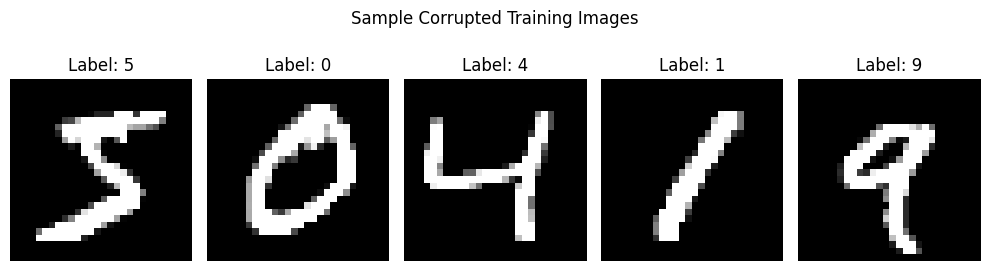


Training an ensemble of 5 models...
Training model 1/5...
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 48s 60ms/step - accuracy: 0.6334 - loss: 1.0802 - val_accuracy: 0.9687 - val_loss: 0.1097
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.9423 - loss: 0.1959 - val_accuracy: 0.9795 - val_loss: 0.0698
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.9581 - loss: 0.1404 - val_accuracy: 0.9835 - val_loss: 0.0533
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.9683 - loss: 0.1077 - val_accuracy: 0.9844 - val_loss: 0.0527
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.9713 - loss: 0.0962 - val_accuracy: 0.9864 - val_loss: 0.0462
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.9738 - loss: 0.0867 - val_accuracy: 0.9890 - val_loss: 0.0404
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.9759 - loss: 0.0759 - val_accuracy: 0.9887 - val_loss: 0.0403
Epoch 8/10
750/750 ━━━━━━━━━━━━

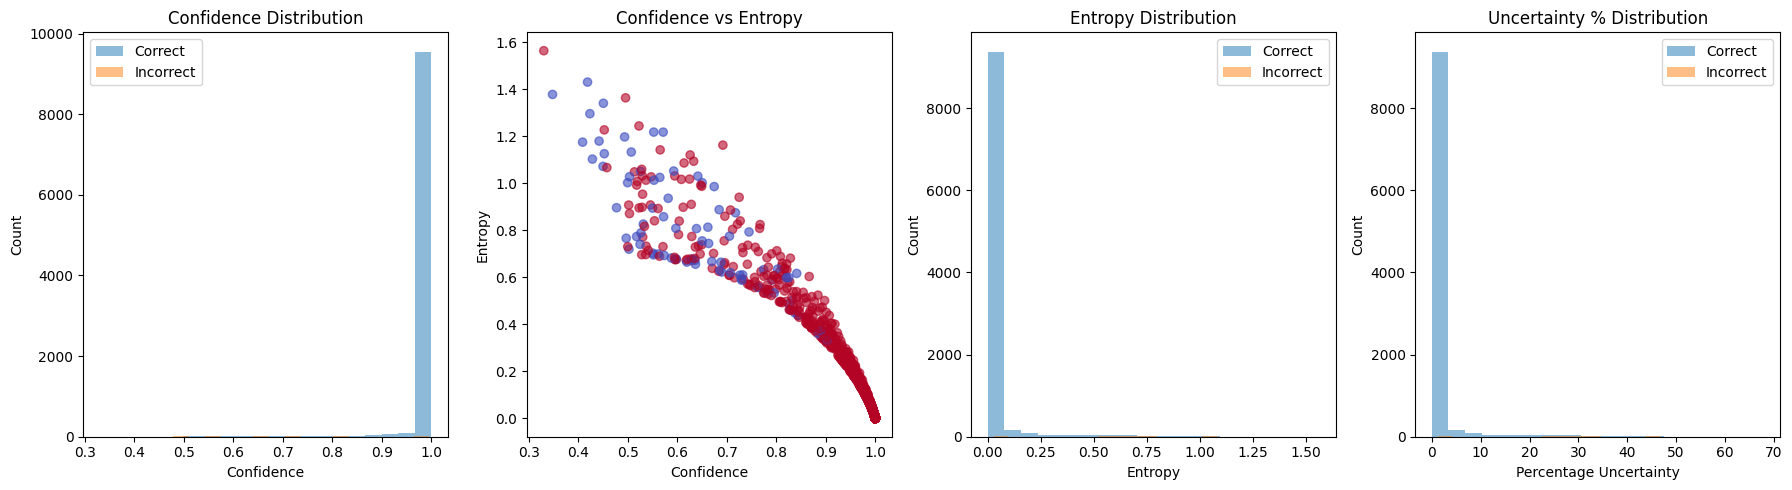

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

#set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#mount Google Drive
from google.colab import drive
 

def load_corrupted_data():
    """Load corrupted data from mnist_c folder in Google Drive"""
    base_path = Path("/content/drive/MyDrive/STC710/mnist_c/brightness")   

    x_train = np.load(base_path / "train_images.npy")
    y_train = np.load(base_path / "train_labels.npy")
    x_test = np.load(base_path / "test_images.npy")
    y_test = np.load(base_path / "test_labels.npy")

    #adding channel dims and normalising
    x_train = x_train[..., None] / 255.0
    x_test = x_test[..., None] / 255.0

    return x_train, y_train, x_test, y_test

def visualize_corruptions(images, labels, n_samples=5, title=""):
    """Plot sample corrupted images"""
    plt.figure(figsize=(10, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def create_emc_dropout_models(n_models=5,  T=50):
    """Create an ensemble of CNN models with MC Dropout layers."""
    ensemble = []
    for _ in range(n_models):
        inputs = Input(shape=(28, 28, 1))

        x = Conv2D(32, 3, activation='relu')(inputs)
        x = MaxPooling2D()(x)
        x = Dropout(0.25)(x)

        x = Conv2D(64, 3, activation='relu')(x)
        x = MaxPooling2D()(x)
        x = Dropout(0.25)(x)

        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.5)(x)

        outputs = Dense(10, activation='softmax')(x)

        model = Model(inputs, outputs)
        ensemble.append(model)
    return ensemble

def train_model(model, x_train, y_train):
    """Train model on corrupted data"""
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model.fit(x_train, y_train,
                     batch_size=64,
                     epochs=10,
                     validation_split=0.2)


def emc_predict(ensemble, x):
    """Make EMC Dropout predictions with uncertainty."""
    predictions = []
    for model in ensemble:
        #predict with each model in the ensemble. Dropout is off by default in .predict()
        model_predictions = model.predict(x)
        predictions.append(model_predictions)
    #stack predictions along a new axis (ensemble size)
    return np.stack(predictions, axis=0)


def analyze_results(predictions, true_labels):
    """Analyze model performance on corrupted data with uncertainty quantification"""
    if predictions is None or len(predictions) == 0:
        raise ValueError("No predictions provided to analyze_results")

    # Mean prediction and predicted classes
    mean_probs = np.mean(predictions, axis=0)
    preds = np.argmax(mean_probs, axis=1)
    std_dev = np.std(predictions, axis=0)

    #performance metrics
    accuracy = np.mean(preds == true_labels)
    entropies = -np.sum(mean_probs * np.log(mean_probs + 1e-10), axis=1)
    max_entropy = -np.log(1 / 10)
    percentage_uncertainty = (entropies / max_entropy) * 100
    avg_std_dev = np.mean(std_dev, axis=1)
    percentage_uncertainty_std = np.mean(avg_std_dev) * 100


    print(f"Accuracy on corrupted data: {accuracy:.4f}")
    print(f"Average predictive entropy: {np.mean(entropies):.4f}")
    print(f"Average % uncertainty (entropy-based): {np.mean(percentage_uncertainty):.2f}%")
    print(f"Average % uncertainty (std-dev-based): {percentage_uncertainty_std:.2f}%")
    print(f"Error rate: {1 - accuracy:.4f}")


    # Visualizations
    plt.figure(figsize=(18, 5))

    confidences = np.max(mean_probs, axis=1)
    correct = preds == true_labels

    plt.subplot(1, 4, 1)
    plt.hist(confidences[correct], bins=20, alpha=0.5, label='Correct')
    plt.hist(confidences[~correct], bins=20, alpha=0.5, label='Incorrect')
    plt.xlabel("Confidence"), plt.ylabel("Count"), plt.legend()
    plt.title("Confidence Distribution")

    plt.subplot(1, 4, 2)
    plt.scatter(confidences, entropies, c=correct, cmap='coolwarm', alpha=0.6)
    plt.xlabel("Confidence"), plt.ylabel("Entropy")
    plt.title("Confidence vs Entropy")

    plt.subplot(1, 4, 3)
    plt.hist(entropies[correct], bins=20, alpha=0.5, label='Correct')
    plt.hist(entropies[~correct], bins=20, alpha=0.5, label='Incorrect')
    plt.xlabel("Entropy"), plt.ylabel("Count"), plt.legend()
    plt.title("Entropy Distribution")

    plt.subplot(1, 4, 4)
    plt.hist(percentage_uncertainty[correct], bins=20, alpha=0.5, label='Correct')
    plt.hist(percentage_uncertainty[~correct], bins=20, alpha=0.5, label='Incorrect')
    plt.xlabel("Percentage Uncertainty"), plt.ylabel("Count"), plt.legend()
    plt.title("Uncertainty % Distribution")


    plt.tight_layout()
    plt.show()

# ==== Main execution ====
try:
    #load corrupted data
    x_train, y_train, x_test, y_test = load_corrupted_data()

    #visualize some corrupted examples
    visualize_corruptions(x_train[:5] * 255, y_train[:5], title="Sample Corrupted Training Images")

    #create and train ensemble of models
    n_models = 5 # Define the number of models in the ensemble
    ensemble = create_emc_dropout_models(n_models=n_models)

    #train each model in the ensemble
    print(f"\nTraining an ensemble of {n_models} models...")
    for i, model in enumerate(ensemble):
        print(f"Training model {i+1}/{n_models}...")
        #reset model state if needed, or train from scratch each time
        #for simplicity, i train each model independently here.
         
        #recreate a fresh model instance to train to ensure independent initialization
        model_to_train = create_emc_dropout_models(n_models=1)[0]
        history = train_model(model_to_train, x_train, y_train)
        #store the trained model back into the ensemble list
        ensemble[i] = model_to_train


    
    print("\nEvaluating on corrupted test data using EMC...")
    #use the trained ensemble for prediction
    predictions = emc_predict(ensemble, x_test)
    analyze_results(predictions, y_test)

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Verify files exist at: /content/gdrive/MyDrive/STC710/mnist_c/brightness/")
    print("2. Check file names: train_images.npy, train_labels.npy, test_images.npy, test_labels.npy")
    print("3. Ensure Drive is mounted properly")
    print("4. Check the image shape: expected (N, 28, 28) or (N, 28, 28, 1)")
    print("5. Ensure the 'mnist_c' dataset is correctly placed in your Google Drive.")